# BC4 

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

May 2022

https://github.com/fpontejos/bc4


## Initial Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil
from datetime import timedelta, datetime
import os
import re
import warnings
import itertools
import collections
import ta

warnings.filterwarnings('ignore')



In [2]:
from matplotlib.colors import LinearSegmentedColormap


In [3]:
from functools import reduce

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


In [5]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()


### Variables

In [6]:
COLORS = ['#2ec4b6', '#1e9fb4', '#0f7ab2', '#285892', '#49306b', '#7a3161', '#a13258', '#c63351', '#ea3449']

CAT_COLORS = ['#2EC4B6', '#0E79B2', '#49306B', '#9A325A', '#EA3449']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = ['#0e79b2', '#4b9ac3', '#84b8d4', '#bcd6e4', '#f4f4f4', '#c6c0d0', '#9b8eac', '#715e8b', '#49306b']

DIV_COL_HALF = ['#f4f4f4', '#bed3da', '#8ab2bf', '#5592a5', '#20718b']

UMP_COLORS = ['#22446D', '#FC9E4F', '#AB2346' ,'#6ABB5D']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
DIVHALF_PALETTE = sns.color_palette(DIV_COL_HALF)
CAT_PALETTE = sns.color_palette(CAT_COLORS)
UMP_PALETTE = sns.color_palette(UMP_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
DIV_H_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COL_HALF)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)
UMP_CMAP = LinearSegmentedColormap.from_list("ump_colors", UMP_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = True
RANDOM_STATE = 9

IMG_PATH = '../imgs/'
DATA_IN_PATH = '../../source/data_updated/'
DATA_OUT_PATH = '../../data_out/'


In [7]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight', transparent=True)
        


### Styles

In [8]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 128

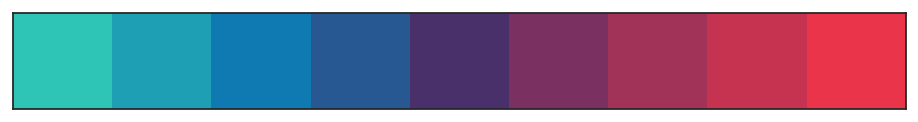

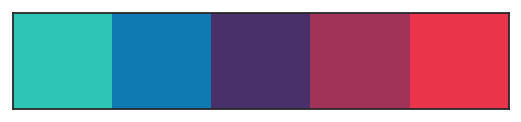

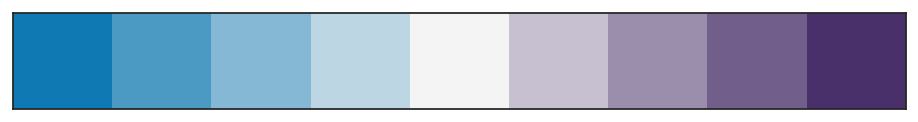

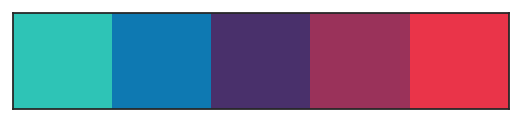

In [9]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Load Data

In [10]:
df_adjclose = pd.read_csv(DATA_IN_PATH + "adj_close.csv")
#df_adjclose.head(3)

In [11]:
df_close = pd.read_csv(DATA_IN_PATH + "close.csv")
#df_close.head(3)

In [12]:
df_high = pd.read_csv(DATA_IN_PATH + "high.csv")
#df_high.head(3)

In [13]:
df_low = pd.read_csv(DATA_IN_PATH + "low.csv")
#df_low.head(3)

In [14]:
df_open = pd.read_csv(DATA_IN_PATH + "open.csv")
#df_open.head(3)

In [15]:
df_vol = pd.read_csv(DATA_IN_PATH + "volume.csv")
#df_vol.head(3)

In [16]:
df_list = [df_adjclose,df_close,df_high,df_low]

In [17]:
def assemble_coin_df(coin_i):
    df_data = df_close[['Date',coin_i]].rename(columns={coin_i:'close'})\
            .merge(df_high[['Date',coin_i]].rename(columns={coin_i:'high'}), left_on='Date', right_on='Date')\
            .merge(df_low[['Date',coin_i]].rename(columns={coin_i:'low'}), left_on='Date', right_on='Date')\
            .merge(df_open[['Date',coin_i]].rename(columns={coin_i:'open'}), left_on='Date', right_on='Date')\
            .merge(df_vol[['Date',coin_i]].rename(columns={coin_i:'volume'}), left_on='Date', right_on='Date')
    return df_data


df_ada   = assemble_coin_df('ADA-USD')
df_atom  = assemble_coin_df('ATOM-USD')
df_avax  = assemble_coin_df('AVAX-USD')
df_axs   = assemble_coin_df('AXS-USD')
df_btc   = assemble_coin_df('BTC-USD')
df_eth   = assemble_coin_df('ETH-USD')
df_link  = assemble_coin_df('LINK-USD')
df_luna1 = assemble_coin_df('LUNA1-USD')
df_matic = assemble_coin_df('MATIC-USD')
df_sol   = assemble_coin_df('SOL-USD')



In [18]:
## There are two days with prices, then a long period without. 
## Remove these two days.

df_avax.loc[df_avax['Date']=='2020-07-13',['close', 'high', 'low', 'open', 'volume']] = np.nan
df_avax.loc[df_avax['Date']=='2020-07-14',['close', 'high', 'low', 'open', 'volume']] = np.nan
df_avax.loc[df_avax['Date']>='2020-07-13',['close', 'high', 'low', 'open', 'volume']]


,close,high,low,open,volume
1161,NaN,NaN,NaN,NaN,NaN
1162,NaN,NaN,NaN,NaN,NaN
1163,NaN,NaN,NaN,NaN,NaN
1164,NaN,NaN,NaN,NaN,NaN
1165,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1821,67.086105,67.282066,59.498161,59.658340,8.757237e+08
1822,59.127441,69.349014,57.024452,67.076157,1.259826e+09
1823,57.034325,59.306812,55.412495,59.121109,8.872802e+08
1824,55.156693,57.439198,53.625706,57.035454,5.551183e+08


In [19]:
df_avax.columns

Index(['Date', 'close', 'high', 'low', 'open', 'volume'], dtype='object')

In [20]:
df_coins_list = [df_ada, df_atom, df_avax, df_axs, df_btc, df_eth, df_link, df_luna1, df_matic, df_sol]
df_coins_suff = ['ada', 'atom', 'avax', 'axs', 'btc', 'eth', 'link', 'luna1', 'matic', 'sol']

In [21]:
for i in range(len(df_coins_suff)):
    di = df_coins_list[i]
    df_coins_list[i] = df_coins_list[i].add_prefix(df_coins_suff[i]+'_')
    date_col = df_coins_suff[i]+'_Date'
    df_coins_list[i].rename(columns={date_col: 'Date'}, inplace=True)
    

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='left'), df_coins_list)

In [22]:
df_merged['Date'].min()

'2017-05-09'

In [23]:
df_merged['Date'].max()

'2022-05-08'

In [24]:
df_merged

,Date,ada_close,ada_high,ada_low,ada_open,ada_volume,atom_close,atom_high,atom_low,atom_open,...,matic_close,matic_high,matic_low,matic_open,matic_volume,sol_close,sol_high,sol_low,sol_open,sol_volume
0,2017-05-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-05-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-05-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2022-05-04,0.896942,0.897661,0.769638,0.771107,1.516023e+09,19.876862,19.987272,17.563868,17.593870,...,1.171032,1.171143,1.073876,1.075928,742971942.0,92.770851,92.937195,85.728065,85.841728,1.428455e+09
1822,2022-05-05,0.791152,0.904111,0.778141,0.897061,1.802129e+09,17.853285,20.270138,17.410774,19.871162,...,1.064691,1.185085,1.035494,1.170986,759187845.0,84.596024,95.032822,81.834869,92.769791,1.805979e+09
1823,2022-05-06,0.783359,0.798315,0.765742,0.791065,1.312284e+09,17.674110,17.950396,17.255348,17.853285,...,1.044133,1.075262,1.022339,1.064479,704670768.0,81.764107,84.646935,80.468613,84.588493,1.585082e+09
1824,2022-05-07,0.761882,0.785116,0.750657,0.783352,8.015589e+08,16.475998,17.680393,16.186054,17.676107,...,1.021204,1.064007,1.000354,1.044149,618880005.0,78.983421,82.180786,77.883232,81.766670,1.139093e+09


## Understanding the Data

In [25]:
df_coins_list[0]

,Date,ada_close,ada_high,ada_low,ada_open,ada_volume
0,2017-05-09,NaN,NaN,NaN,NaN,NaN
1,2017-05-10,NaN,NaN,NaN,NaN,NaN
2,2017-05-11,NaN,NaN,NaN,NaN,NaN
3,2017-05-12,NaN,NaN,NaN,NaN,NaN
4,2017-05-13,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1821,2022-05-04,0.896942,0.897661,0.769638,0.771107,1.516023e+09
1822,2022-05-05,0.791152,0.904111,0.778141,0.897061,1.802129e+09
1823,2022-05-06,0.783359,0.798315,0.765742,0.791065,1.312284e+09
1824,2022-05-07,0.761882,0.785116,0.750657,0.783352,8.015589e+08


In [26]:
print(df_coins_suff[0]+'_high')
df_coins_list[0]['Date'] = pd.to_datetime(df_coins_list[0]['Date']).dt.date
df_coins_list[0].set_index('Date')


ada_high


,ada_close,ada_high,ada_low,ada_open,ada_volume
Date,,,,,
2017-05-09,NaN,NaN,NaN,NaN,NaN
2017-05-10,NaN,NaN,NaN,NaN,NaN
2017-05-11,NaN,NaN,NaN,NaN,NaN
2017-05-12,NaN,NaN,NaN,NaN,NaN
2017-05-13,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2022-05-04,0.896942,0.897661,0.769638,0.771107,1.516023e+09
2022-05-05,0.791152,0.904111,0.778141,0.897061,1.802129e+09
2022-05-06,0.783359,0.798315,0.765742,0.791065,1.312284e+09


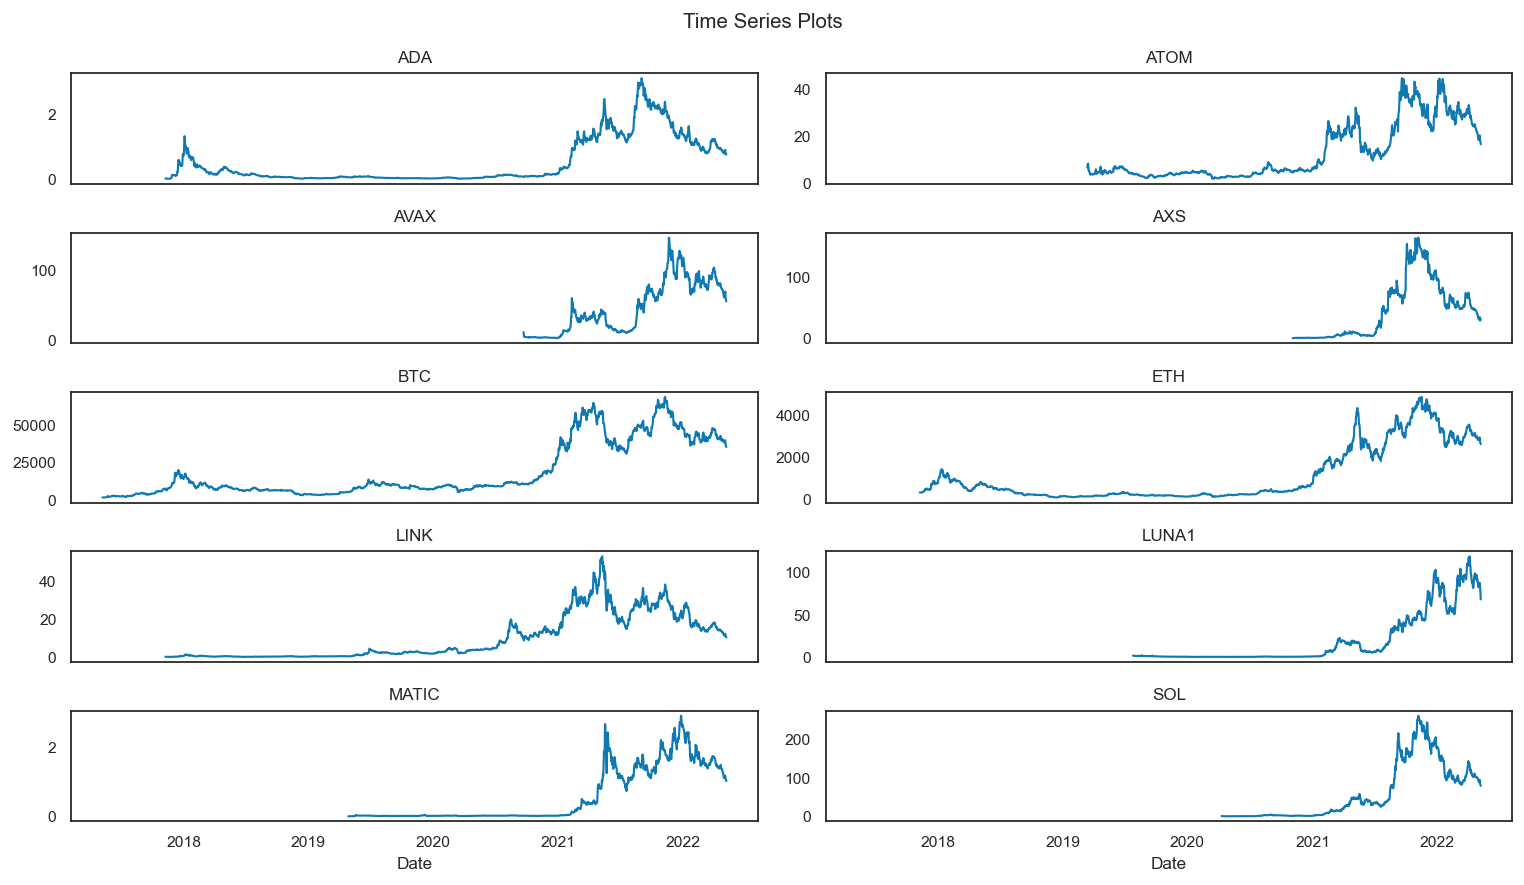

In [27]:
fig, axes = plt.subplots(5,2,figsize=(12,7), sharex=True)

for df_i in range(len(df_coins_list)):
    df_ts = df_coins_list[df_i].copy()
    df_ts['Date'] = pd.to_datetime(df_coins_list[0]['Date']).dt.date
    df_ts.set_index('Date', inplace=True)

    hi = df_coins_suff[df_i]+'_high'
    ci = len(CAT_COLORS)%(df_i+1)
    ax = axes.flatten()[df_i]
    df_ts.loc[:,[hi]].plot(ax=ax, color=CAT_COLORS[1], legend=False)

    ax.set_title(str.upper(df_coins_suff[df_i]))
    #ax.legend([])
    
fig.suptitle("Time Series Plots")
plt.tight_layout()
plt.show()

save_fig("Time Series Plots", fig)


In [28]:
#df_merged

## Get external data

In [29]:
def rename_cols(df, prefix):
    new_names = {
        'Open':prefix+'_open',
        'High':prefix+'_high',
        'Low':prefix+'_low',
        'Close':prefix+'_close',
        'Adj Close':prefix+'_adj_close',
        'Volume':prefix+'_volume',
    }
    return df.rename(columns=new_names)



In [30]:
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

START_DATE = df_merged['Date'].min().strftime('%Y-%m-%d')
END_DATE_ = (df_merged['Date'].max() + timedelta(days=1)).strftime('%Y-%m-%d') 
END_DATE = df_merged['Date'].max().strftime('%Y-%m-%d') 

print(START_DATE, END_DATE, END_DATE_)

2017-05-09 2022-05-08 2022-05-09


In [31]:
#data = pdr.get_data_yahoo("NIM", start=START_DATE, end=END_DATE)

In [32]:
## Gold prices as proxy for risk-aversion
gold_symbol = "GC=F"
gold_data = pdr.get_data_yahoo(gold_symbol, start=START_DATE, end=END_DATE_)
gold_data = gold_data.reset_index()

[*********************100%***********************]  1 of 1 completed


In [33]:
gold_data['Date'] = pd.to_datetime(gold_data['Date'])#.dt.date
gold_data.drop(columns=['Adj Close'], inplace=True)
gold_data = rename_cols(gold_data, 'gold')

In [34]:
## SP500 prices 
spy_symbol = "SPY"
spy_data = pdr.get_data_yahoo(spy_symbol, start=START_DATE, end=END_DATE_)
spy_data = spy_data.reset_index()

[*********************100%***********************]  1 of 1 completed


In [35]:
spy_data['Date'] = pd.to_datetime(spy_data['Date'])#.dt.date
spy_data.drop(columns=['Adj Close'], inplace=True)
spy_data = rename_cols(spy_data, 'spy')


In [36]:
## VIX prices 
vix_symbol = "^VIX"
vix_data = pdr.get_data_yahoo(vix_symbol, start=START_DATE, end=END_DATE_)
vix_data = vix_data.reset_index()

[*********************100%***********************]  1 of 1 completed


In [37]:
vix_data['Date'] = pd.to_datetime(vix_data['Date'])#.dt.date
vix_data.drop(columns=['Adj Close', 'Volume'], inplace=True)
vix_data = rename_cols(vix_data, 'vix')


In [38]:
exog_ = pd.DataFrame(pd.period_range(START_DATE, END_DATE,freq='D'), columns=['Date'])
exog_['Date2'] = pd.to_datetime((exog_['Date']).astype("str"))
exog_.set_index('Date', inplace=True)


exog_merged = exog_.merge(gold_data, left_on='Date2', right_on='Date', how='left')
exog_merged = exog_merged.merge(spy_data, left_on='Date2', right_on='Date', how='left').drop(columns=['Date_x'])
exog_merged = exog_merged.merge(vix_data, left_on='Date2', right_on='Date', how='left').drop(columns=['Date_y'])

exog_merged = exog_merged.drop(columns=['Date']).rename(columns={'Date2':'Date'})
exog_merged.fillna(method='ffill', inplace=True)
exog_merged


,Date,gold_open,gold_high,gold_low,gold_close,gold_volume,spy_open,spy_high,spy_low,spy_close,spy_volume,vix_open,vix_high,vix_low,vix_close
0,2017-05-09,1226.099976,1226.199951,1214.000000,1214.300049,55.0,239.960007,240.190002,239.039993,239.440002,51363200.0,9.870000,10.140000,9.560000,9.960000
1,2017-05-10,1219.800049,1220.199951,1217.300049,1217.300049,23.0,239.389999,239.869995,239.149994,239.869995,54293800.0,9.750000,10.240000,9.620000,10.210000
2,2017-05-11,1218.500000,1222.699951,1218.300049,1222.699951,13.0,239.350006,239.570007,238.130005,239.380005,62358300.0,10.340000,11.230000,10.320000,10.600000
3,2017-05-12,1228.000000,1229.500000,1226.099976,1226.199951,29.0,239.089996,239.429993,238.669998,238.979996,53912700.0,10.720000,10.870000,10.280000,10.400000
4,2017-05-13,1228.000000,1229.500000,1226.099976,1226.199951,29.0,239.089996,239.429993,238.669998,238.979996,53912700.0,10.720000,10.870000,10.280000,10.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2022-05-04,1867.000000,1867.000000,1867.000000,1867.000000,1.0,417.079987,429.660004,413.709991,429.059998,144247900.0,29.120001,29.420000,24.940001,25.420000
1822,2022-05-05,1897.000000,1904.300049,1874.000000,1874.000000,80.0,424.549988,425.000000,409.440002,413.809998,172929100.0,25.969999,33.200001,25.780001,31.200001
1823,2022-05-06,1874.699951,1890.300049,1871.500000,1881.199951,80.0,411.100006,414.799988,405.730011,411.339996,151671300.0,32.230000,35.340000,29.830000,30.190001
1824,2022-05-07,1874.699951,1890.300049,1871.500000,1881.199951,80.0,411.100006,414.799988,405.730011,411.339996,151671300.0,32.230000,35.340000,29.830000,30.190001


In [39]:
df_merged = df_merged.merge(exog_merged, left_on='Date', right_on='Date')

In [40]:
df_merged

,Date,ada_close,ada_high,ada_low,ada_open,ada_volume,atom_close,atom_high,atom_low,atom_open,...,gold_volume,spy_open,spy_high,spy_low,spy_close,spy_volume,vix_open,vix_high,vix_low,vix_close
0,2017-05-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55.0,239.960007,240.190002,239.039993,239.440002,51363200.0,9.870000,10.140000,9.560000,9.960000
1,2017-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,239.389999,239.869995,239.149994,239.869995,54293800.0,9.750000,10.240000,9.620000,10.210000
2,2017-05-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.0,239.350006,239.570007,238.130005,239.380005,62358300.0,10.340000,11.230000,10.320000,10.600000
3,2017-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.0,239.089996,239.429993,238.669998,238.979996,53912700.0,10.720000,10.870000,10.280000,10.400000
4,2017-05-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.0,239.089996,239.429993,238.669998,238.979996,53912700.0,10.720000,10.870000,10.280000,10.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2022-05-04,0.896942,0.897661,0.769638,0.771107,1.516023e+09,19.876862,19.987272,17.563868,17.593870,...,1.0,417.079987,429.660004,413.709991,429.059998,144247900.0,29.120001,29.420000,24.940001,25.420000
1822,2022-05-05,0.791152,0.904111,0.778141,0.897061,1.802129e+09,17.853285,20.270138,17.410774,19.871162,...,80.0,424.549988,425.000000,409.440002,413.809998,172929100.0,25.969999,33.200001,25.780001,31.200001
1823,2022-05-06,0.783359,0.798315,0.765742,0.791065,1.312284e+09,17.674110,17.950396,17.255348,17.853285,...,80.0,411.100006,414.799988,405.730011,411.339996,151671300.0,32.230000,35.340000,29.830000,30.190001
1824,2022-05-07,0.761882,0.785116,0.750657,0.783352,8.015589e+08,16.475998,17.680393,16.186054,17.676107,...,80.0,411.100006,414.799988,405.730011,411.339996,151671300.0,32.230000,35.340000,29.830000,30.190001


In [41]:
df_all_ta = df_merged.copy()

## Get Technical Analysis

In [42]:
ta_inputs = ["open", "high", "low", "close", "volume"]
ta_cols = ['volume_obv','momentum_rsi','trend_macd','volatility_atr']
ta_cols_all = ['volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi',
       'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'momentum_rsi', 'momentum_stoch_rsi',
       'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_tsi',
       'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
       'momentum_ao', 'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'momentum_pvo', 'momentum_pvo_signal',
       'momentum_pvo_hist', 'momentum_kama', 'others_dr', 'others_dlr',
       'others_cr']

In [43]:
rename_ = {}

for i in range(len(ta_cols)):
    rename_[ta_cols[i]] = '_' + ta_cols[i]
rename_

{'volume_obv': '_volume_obv',
 'momentum_rsi': '_momentum_rsi',
 'trend_macd': '_trend_macd',
 'volatility_atr': '_volatility_atr'}

In [44]:
df_ada_ = ta.add_all_ta_features(
    df_ada, "open", "high", "low", "close", "volume", fillna=True
)

In [45]:
#df_ta_ada=
df_ada.loc[:,['Date','volume_obv','momentum_rsi','trend_macd','volatility_atr']]

,Date,volume_obv,momentum_rsi,trend_macd,volatility_atr
0,2017-05-09,0.000000e+00,100.000000,0.000000,0.0
1,2017-05-10,0.000000e+00,100.000000,0.000000,0.0
2,2017-05-11,0.000000e+00,100.000000,0.000000,0.0
3,2017-05-12,0.000000e+00,100.000000,0.000000,0.0
4,2017-05-13,0.000000e+00,100.000000,0.000000,0.0
...,...,...,...,...,...
1821,2022-05-04,1.598847e+11,50.534673,-0.050276,0.0
1822,2022-05-05,1.580825e+11,40.646546,-0.050391,0.0
1823,2022-05-06,1.567702e+11,40.025243,-0.050528,0.0
1824,2022-05-07,1.559687e+11,38.288249,-0.051774,0.0


In [46]:
ta_inputs_ = ["ada_open", "ada_high", "ada_low", "ada_close", "ada_volume"]


In [47]:
df_coins_list[0]

,Date,ada_close,ada_high,ada_low,ada_open,ada_volume
0,2017-05-09,NaN,NaN,NaN,NaN,NaN
1,2017-05-10,NaN,NaN,NaN,NaN,NaN
2,2017-05-11,NaN,NaN,NaN,NaN,NaN
3,2017-05-12,NaN,NaN,NaN,NaN,NaN
4,2017-05-13,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1821,2022-05-04,0.896942,0.897661,0.769638,0.771107,1.516023e+09
1822,2022-05-05,0.791152,0.904111,0.778141,0.897061,1.802129e+09
1823,2022-05-06,0.783359,0.798315,0.765742,0.791065,1.312284e+09
1824,2022-05-07,0.761882,0.785116,0.750657,0.783352,8.015589e+08


In [48]:
def plot_bollinger_bands(df, prefix):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.plot(df[[prefix+'_close']])
    ax.plot(df[['volatility_bbh']], label='High BB')
    ax.plot(df[['volatility_bbl']], label='Low BB')
    ax.plot(df[['volatility_bbm']], label='EMA BB')
    ax.set_title(str.upper(prefix) + ' Bollinger Bands')
    plt.show()
    
    

In [49]:
########################### Plot all the things later

In [50]:
for dfi in range(len(df_coins_list)):
    df_ = df_coins_list[dfi].dropna()
    df_pref_i = df_coins_suff[dfi]
    ta_cols_rename = {}
    for i in range(len(ta_cols)):
        ta_cols_rename[ta_cols[i]] = df_pref_i + '_' + ta_cols[i]
        
    ta_cols_rename_all = {}
    for i in range(len(ta_cols_all)):
        ta_cols_rename_all[ta_cols_all[i]] = df_pref_i + '_' + ta_cols_all[i]

    df_ta_ = ta.add_all_ta_features(
                    df_, 
                    df_pref_i+"_open", 
                    df_pref_i+"_high", 
                    df_pref_i+"_low", 
                    df_pref_i+"_close", 
                    df_pref_i+"_volume", 
                    fillna=True)
    df_ta_['Date'] = pd.to_datetime(df_ta_['Date'])
    df_ta_all_ = df_ta_.copy()

    df_ta_ = df_ta_.loc[:,['Date','volume_obv','momentum_rsi','trend_macd','volatility_atr']]    
    df_ta_.rename(columns=ta_cols_rename, inplace=True)

    
    df_merged = df_merged.merge(df_ta_, left_on='Date', right_on='Date') 
    
    ta_colslist = ['Date'] + ta_cols_all
    df_ta_all_ = df_ta_all_.loc[:,ta_colslist]
    
    df_ta_all_.rename(columns=ta_cols_rename_all, inplace=True)
    df_all_ta = df_all_ta.merge(df_ta_all_, left_on='Date', right_on='Date') 

In [51]:
df_coins_suff

['ada', 'atom', 'avax', 'axs', 'btc', 'eth', 'link', 'luna1', 'matic', 'sol']

## Plot TA

### Bollinger Bands

In [52]:
df_all_ta.set_index('Date', inplace=True)

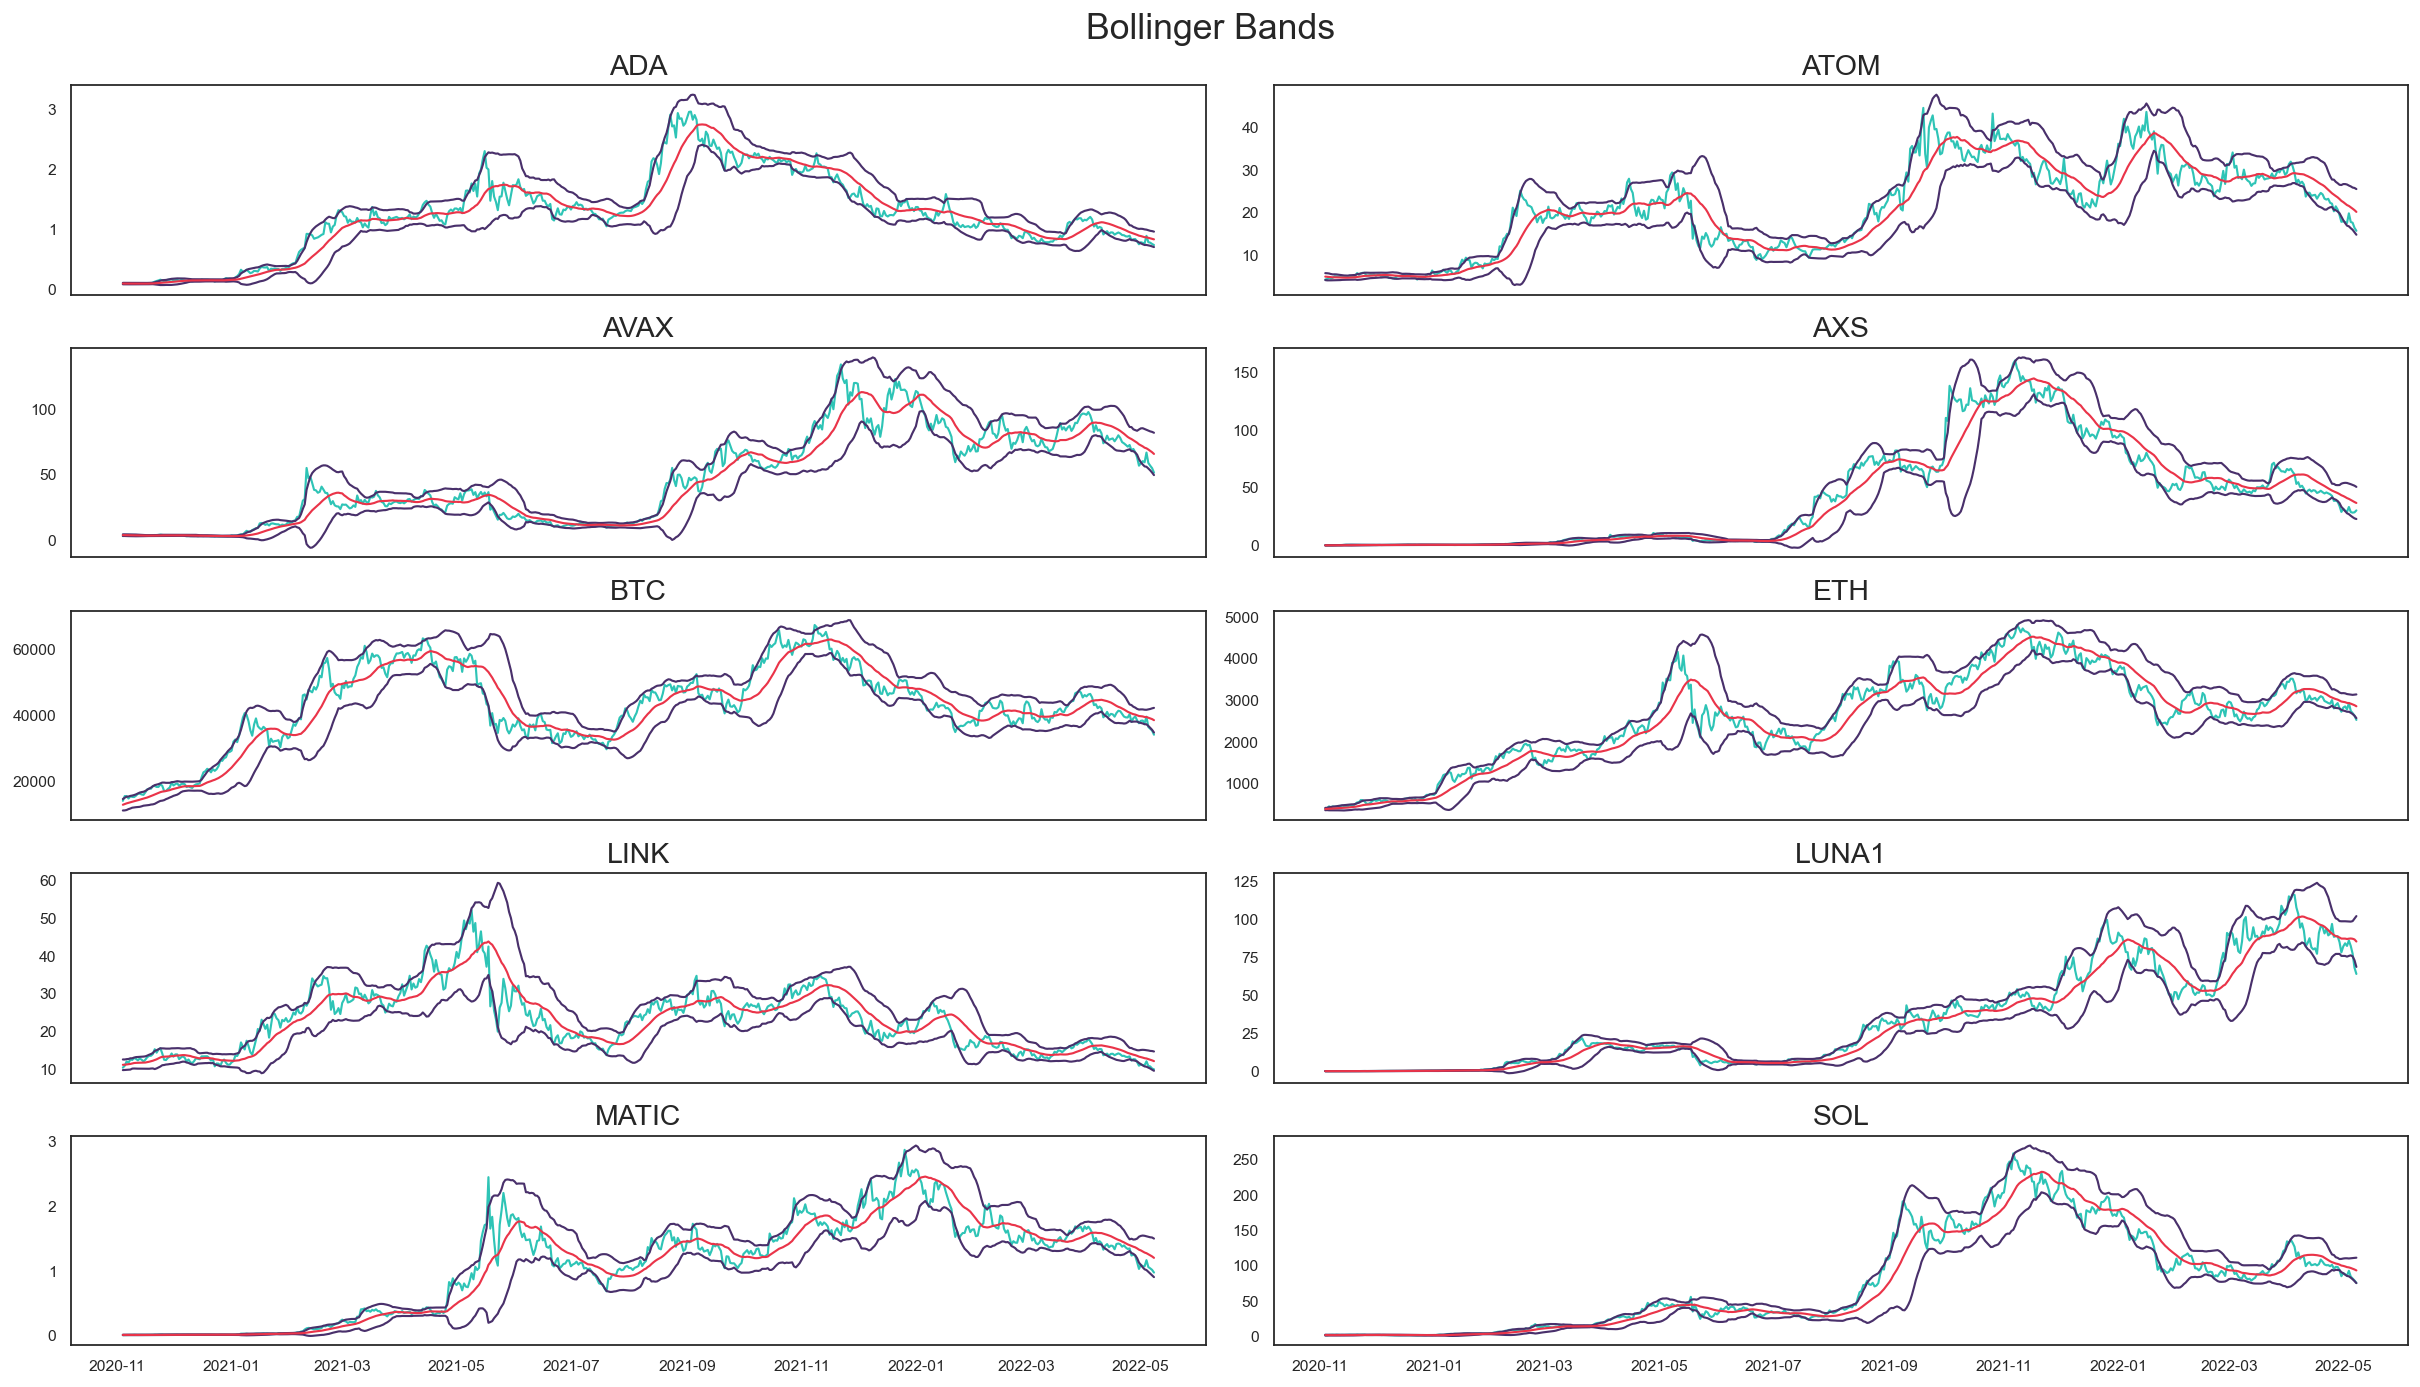

In [53]:
## Plot bollinger bands
fig, axes = plt.subplots(5,2, figsize=(19,11), sharex=True, sharey=False)

for dfi in range(len(df_coins_list)):
    ax = axes.flatten()[dfi]
    plot_prefix = df_coins_suff[dfi]
    ax.set_title(str.upper(plot_prefix), fontsize=16)
    
    ax.plot(df_all_ta[[plot_prefix+'_close']], color=CAT_COLORS[0])
    ax.plot(df_all_ta[[plot_prefix+'_volatility_bbh']], label='High BB', color=CAT_COLORS[2])
    ax.plot(df_all_ta[[plot_prefix+'_volatility_bbl']], label='Low BB', color=CAT_COLORS[2])
    ax.plot(df_all_ta[[plot_prefix+'_volatility_bbm']], label='EMA BB', color=CAT_COLORS[-1])
    
    

fig.suptitle('Bollinger Bands', fontsize=20)
plt.tight_layout()
save_fig('Bollinger Bands', fig)

plt.show()

### MACD

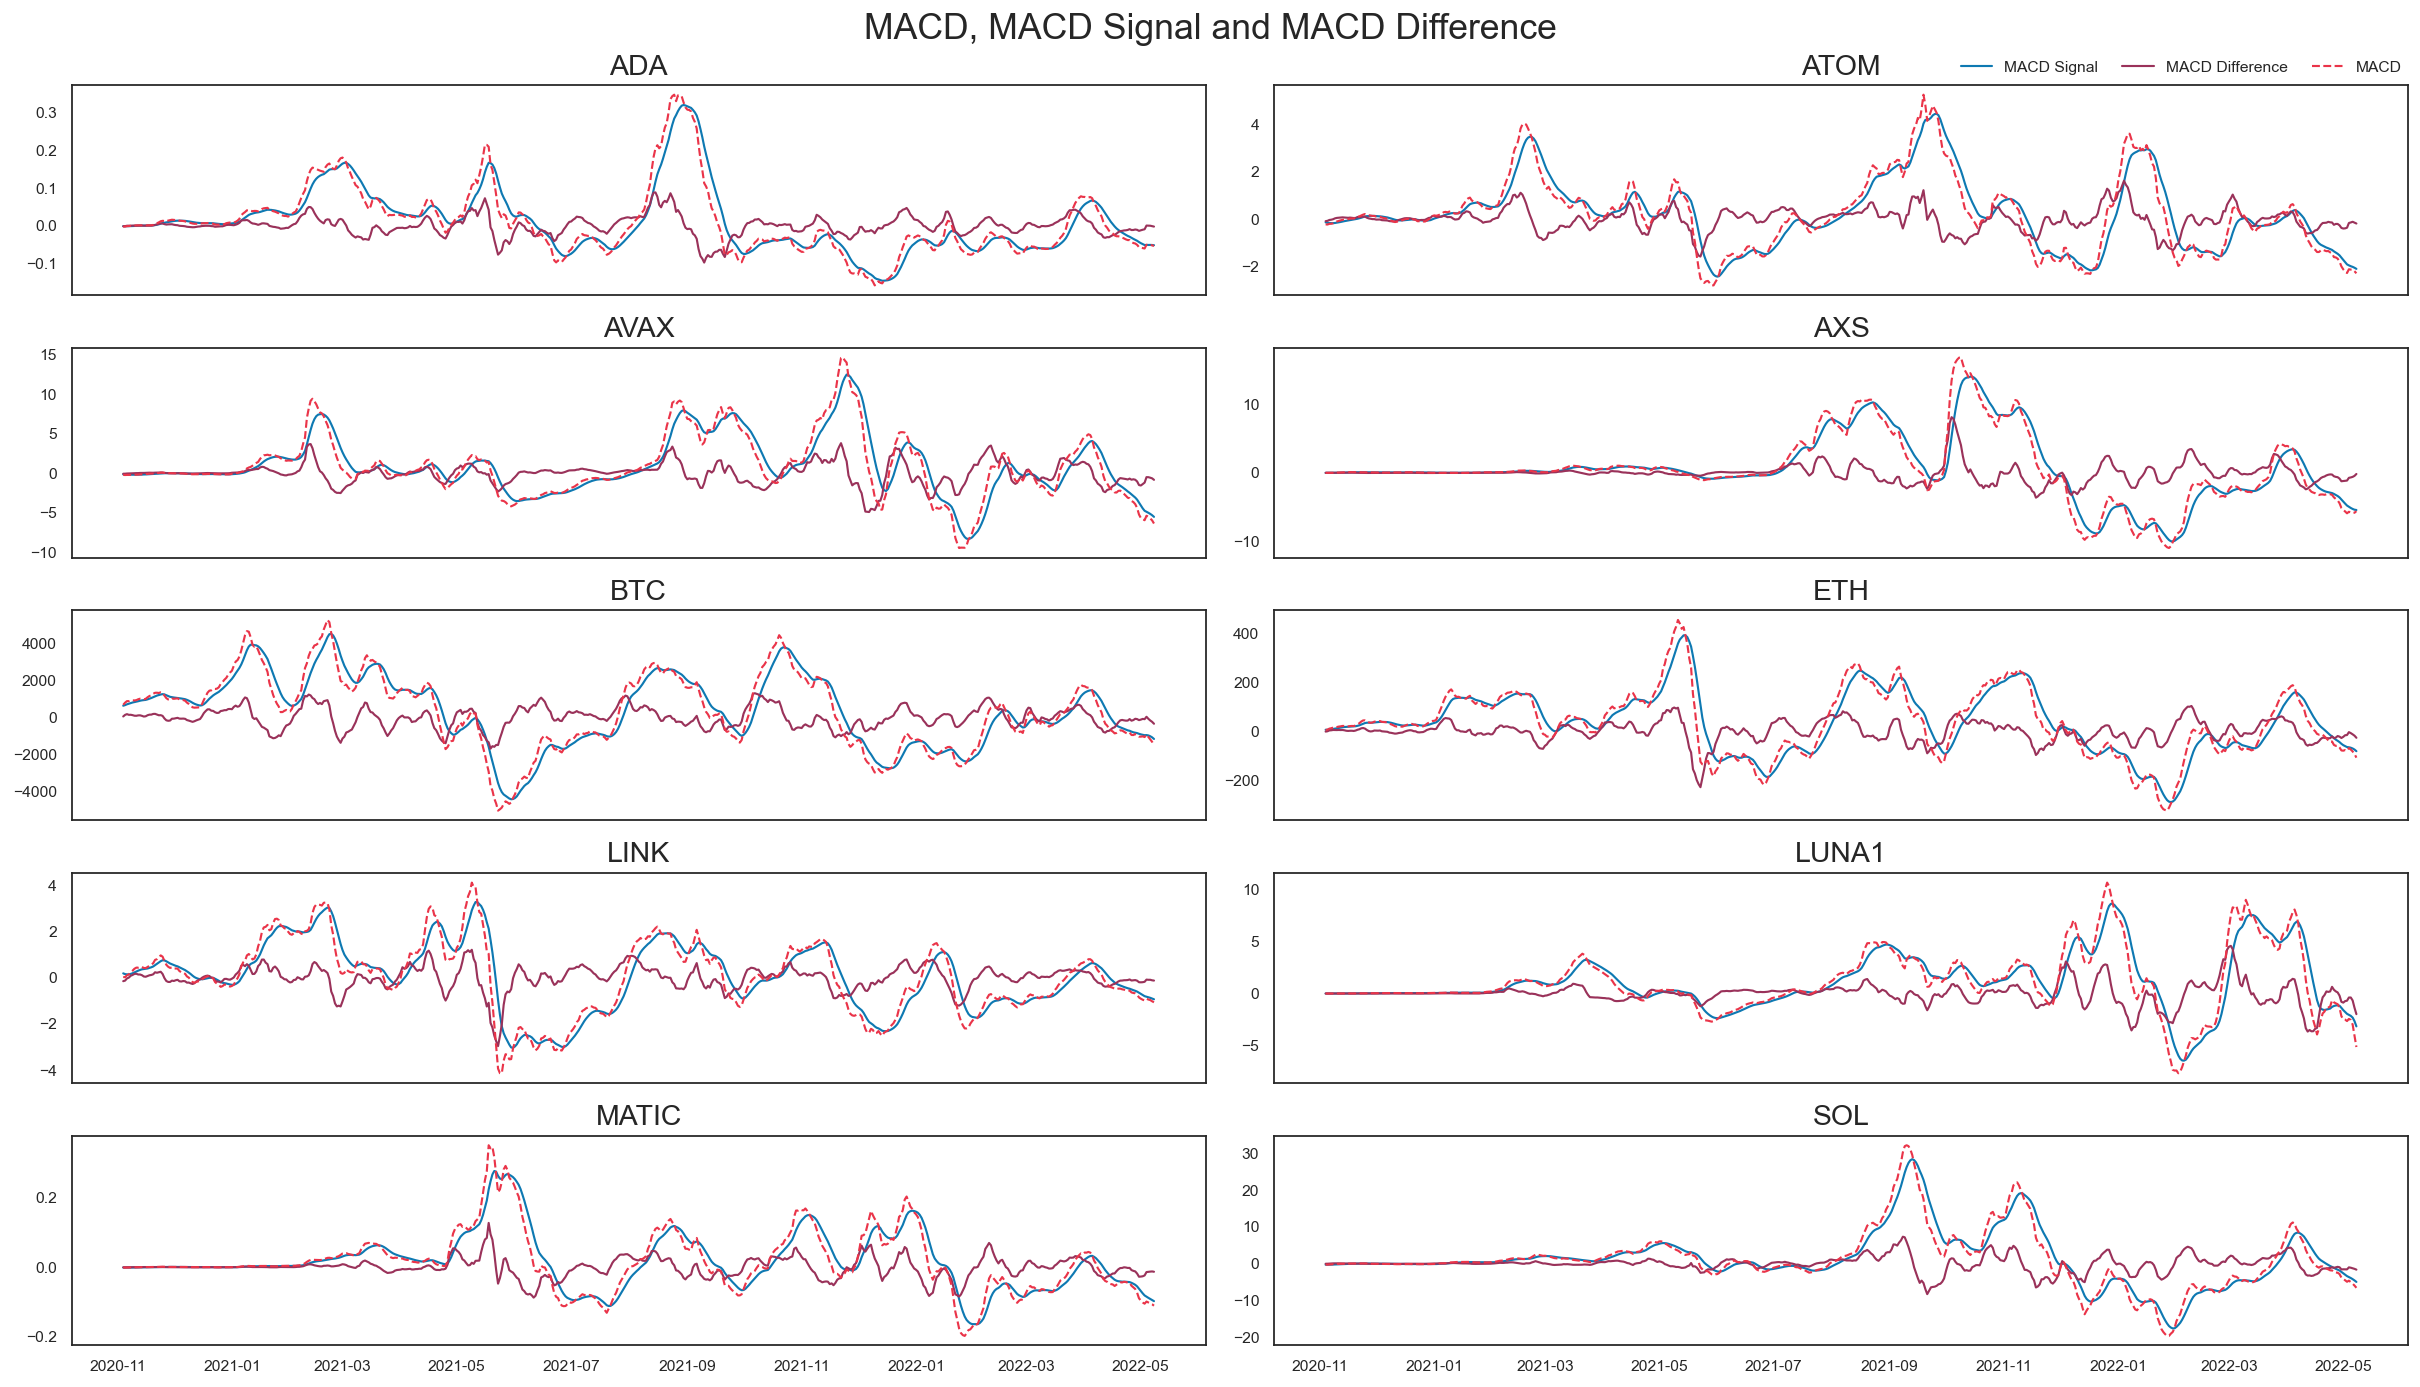

In [54]:
## Plot MACD 
fig, axes = plt.subplots(5,2, figsize=(19,11), sharex=True, sharey=False)

for dfi in range(len(df_coins_list)):
    ax = axes.flatten()[dfi]
    plot_prefix = df_coins_suff[dfi]
    ax.set_title(str.upper(plot_prefix), fontsize=16)
    
    #ax.plot(df_all_ta[[plot_prefix+'_close']], color=CAT_COLORS[0])
    ax.plot(df_all_ta[[plot_prefix+'_trend_macd_signal']], label='MACD Signal', color=CAT_COLORS[1])
    ax.plot(df_all_ta[[plot_prefix+'_trend_macd_diff']], label='MACD Difference', color=CAT_COLORS[3])
    ax.plot(df_all_ta[[plot_prefix+'_trend_macd']], label='MACD', color=CAT_COLORS[-1], linestyle='dashed')
    
    if dfi == 1:
        ax.legend(bbox_to_anchor=(.6, 1.02, .4, .102), loc='lower right',
                      ncol=3, mode="expand", borderaxespad=0., frameon=False)
    
    

fig.suptitle('MACD, MACD Signal and MACD Difference', fontsize=20)
plt.tight_layout()
save_fig('MACD, MACD Signal and MACD Difference', fig)

plt.show()

### RSI

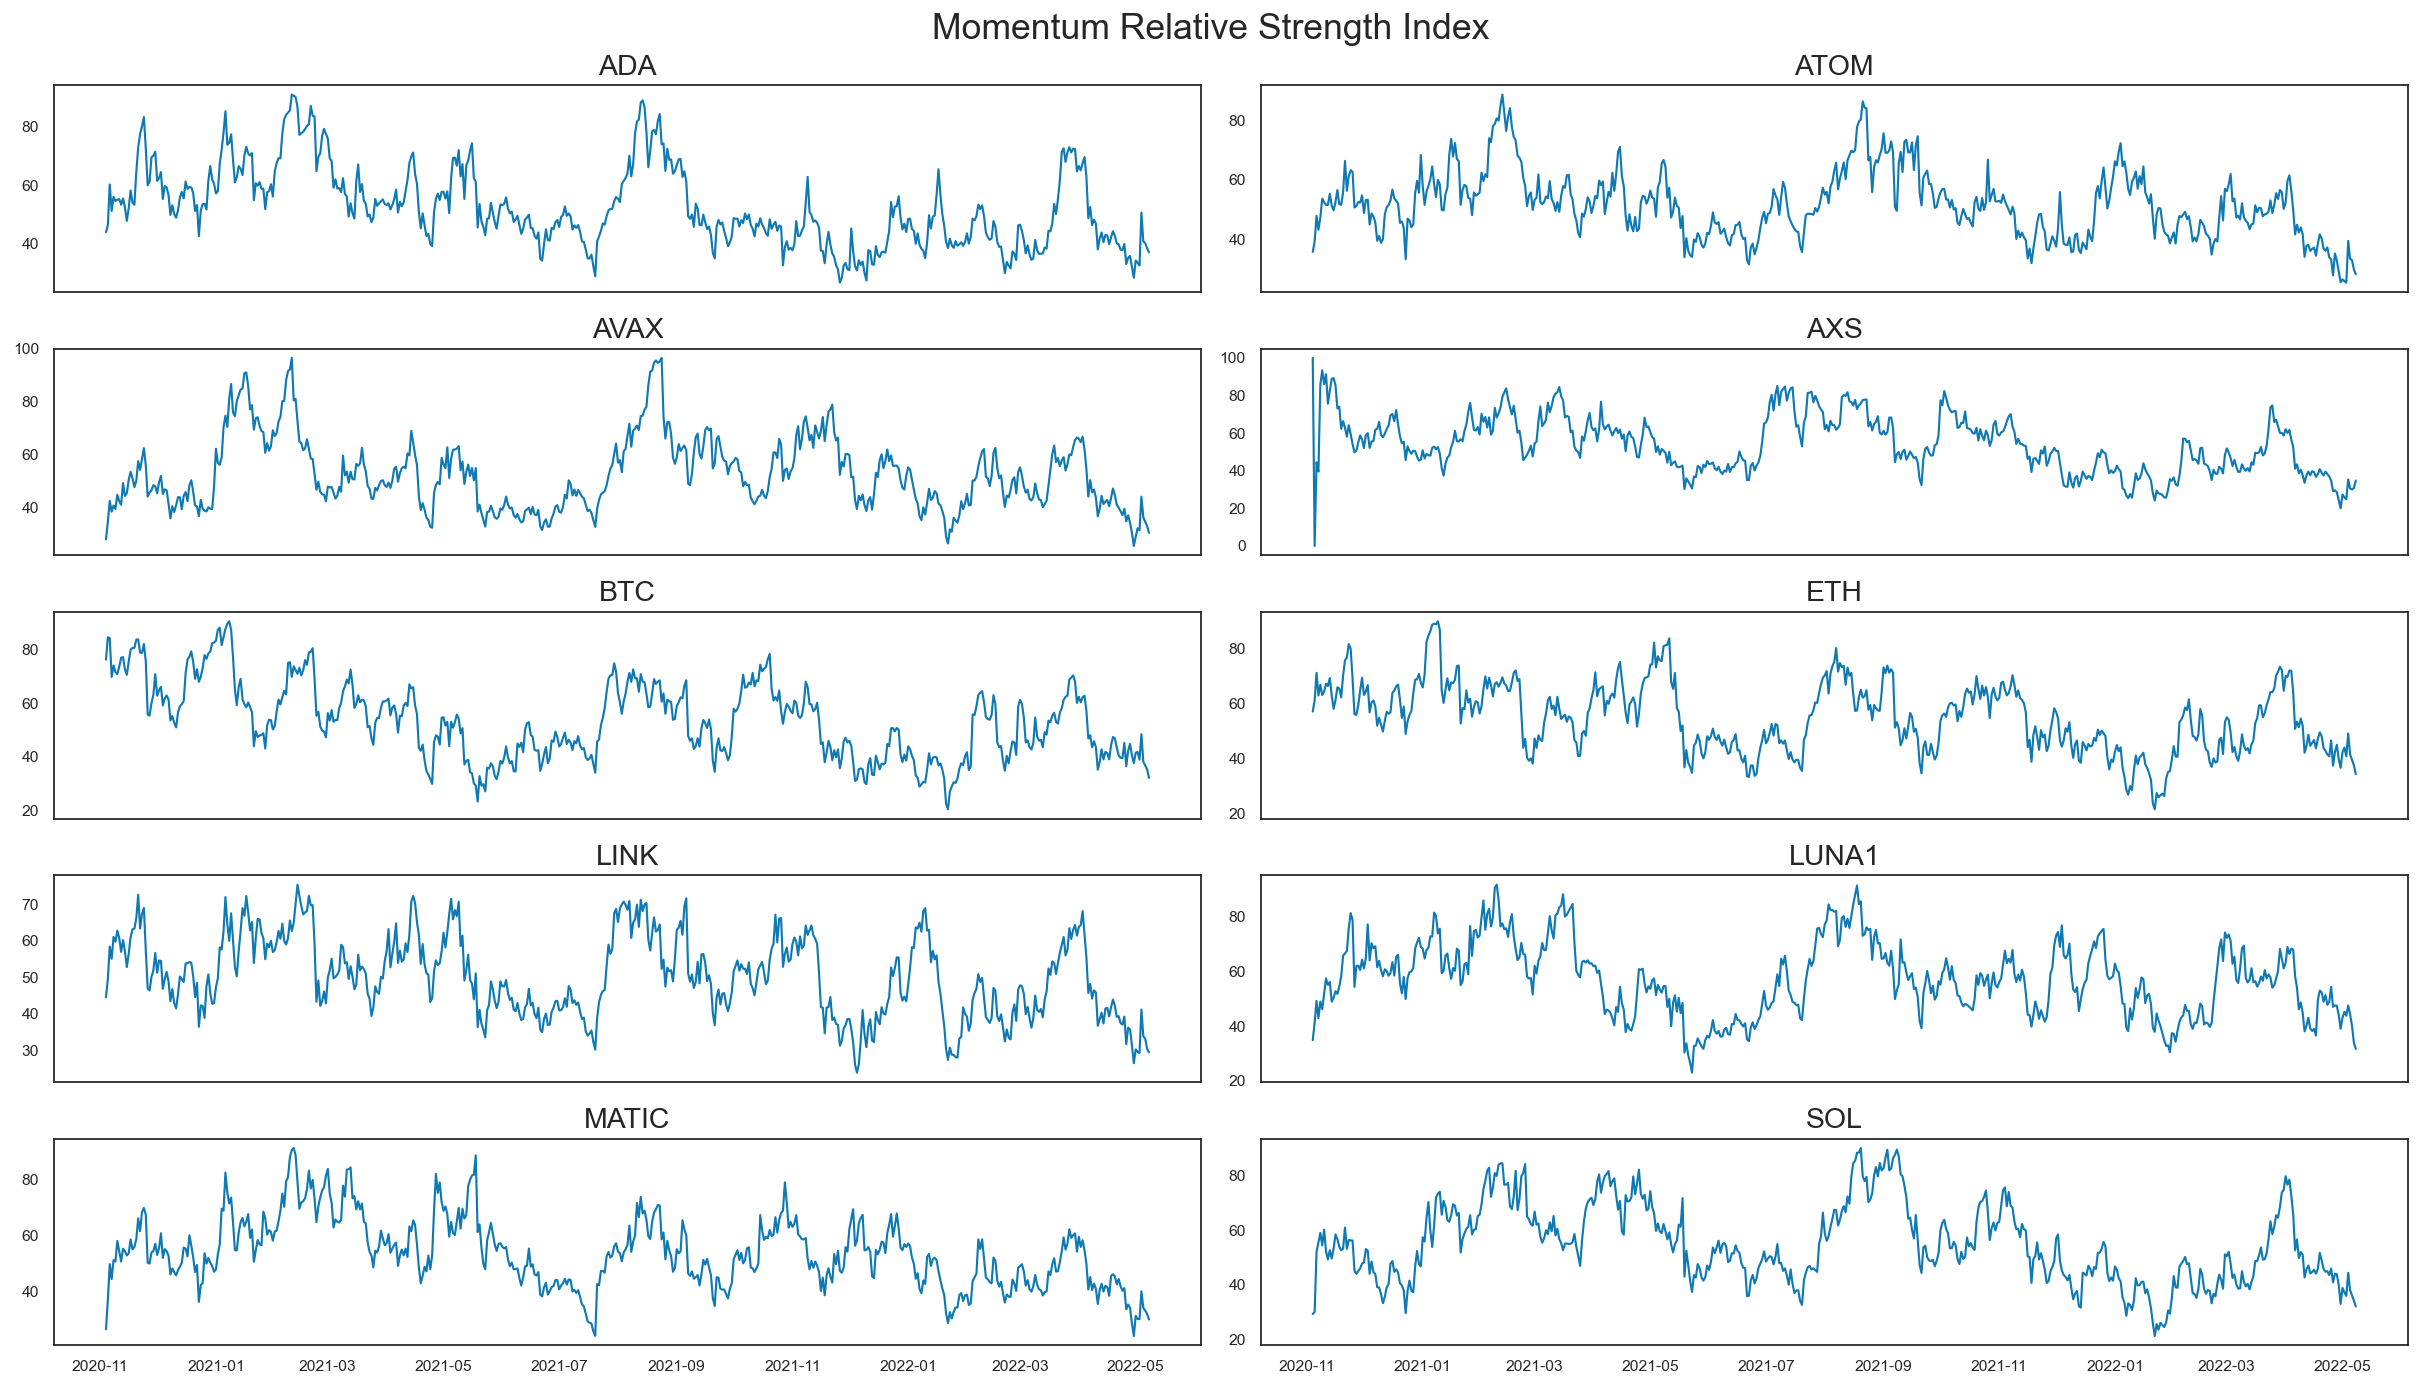

In [55]:
## Plot RSI
fig, axes = plt.subplots(5,2, figsize=(19,11), sharex=True, sharey=False)

for dfi in range(len(df_coins_list)):
    ax = axes.flatten()[dfi]
    plot_prefix = df_coins_suff[dfi]
    ax.set_title(str.upper(plot_prefix), fontsize=16)
    
    #ax.plot(df_all_ta[[plot_prefix+'_close']], label='Close', color=CAT_COLORS[0])
    ax.plot(df_all_ta[[plot_prefix+'_momentum_rsi']], label='RSI', color=CAT_COLORS[1])
        
    

fig.suptitle('Momentum Relative Strength Index', fontsize=20)
plt.tight_layout()
save_fig('RSI', fig)

plt.show()

### ATR

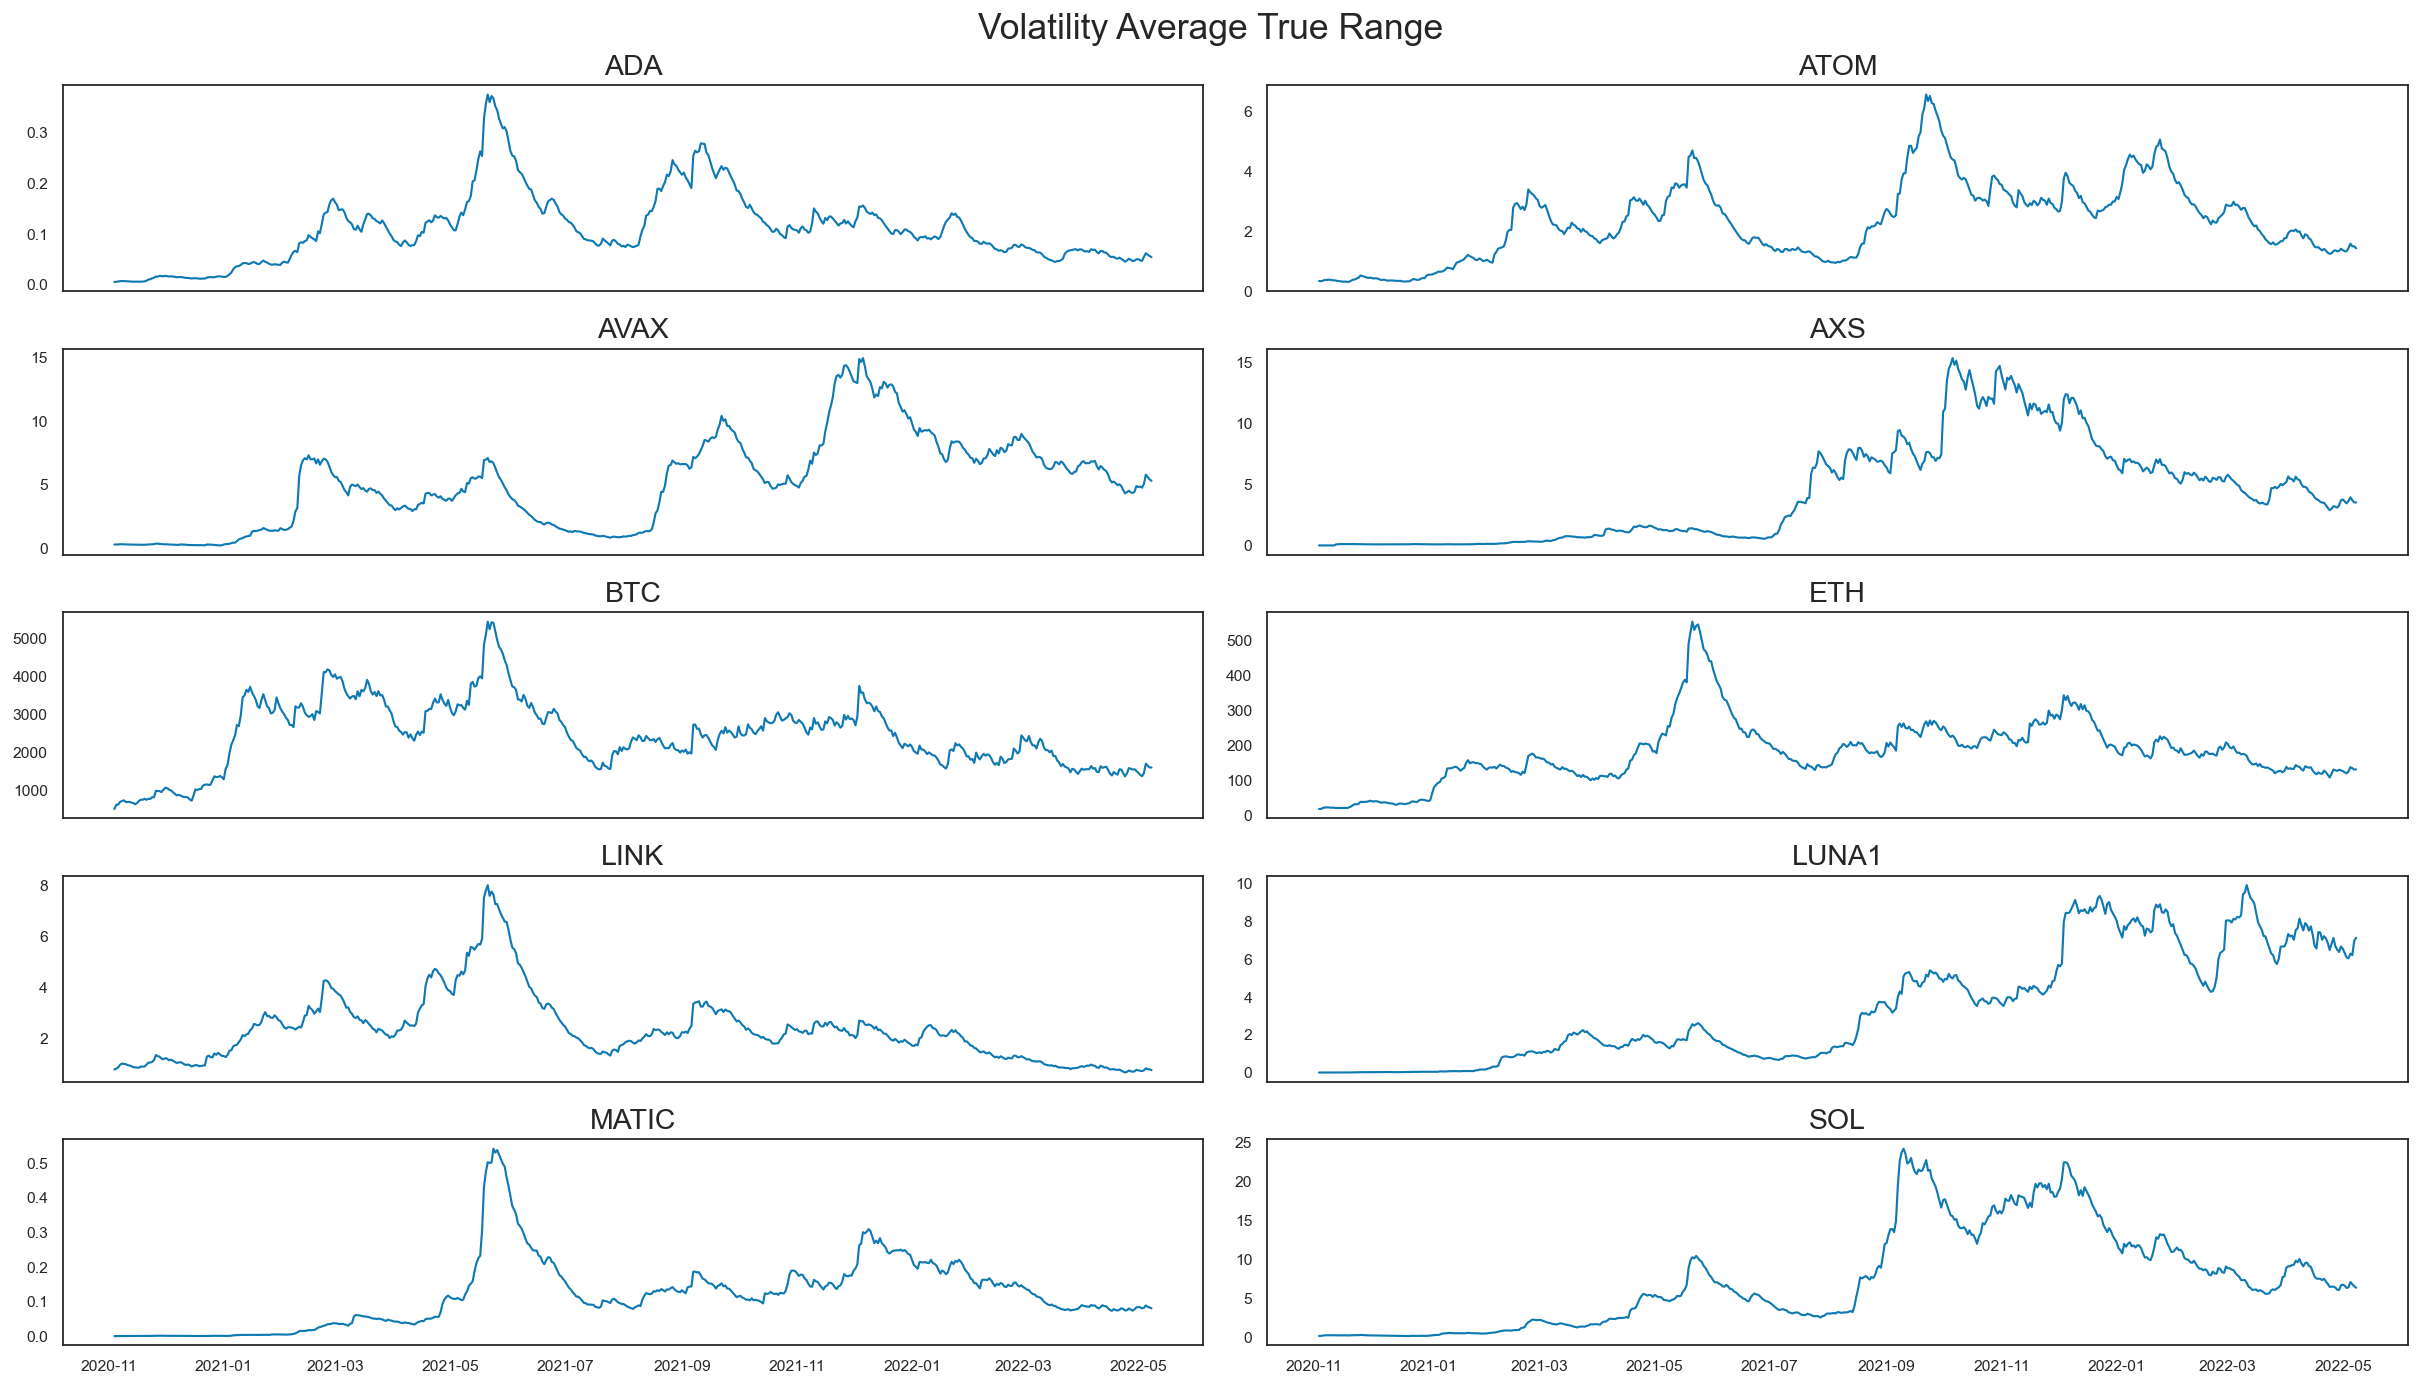

In [56]:
## Plot ATR 
fig, axes = plt.subplots(5,2, figsize=(19,11), sharex=True, sharey=False)

for dfi in range(len(df_coins_list)):
    ax = axes.flatten()[dfi]
    plot_prefix = df_coins_suff[dfi]
    ax.set_title(str.upper(plot_prefix), fontsize=16)
    
    #ax.plot(df_all_ta[[plot_prefix+'_close']], label='Close', color=CAT_COLORS[0])
    ax.plot(df_all_ta[[plot_prefix+'_volatility_atr']], label='ATR', color=CAT_COLORS[1])
        
    

fig.suptitle('Volatility Average True Range', fontsize=20)
plt.tight_layout()
save_fig('ATR', fig)

plt.show()

### OBV

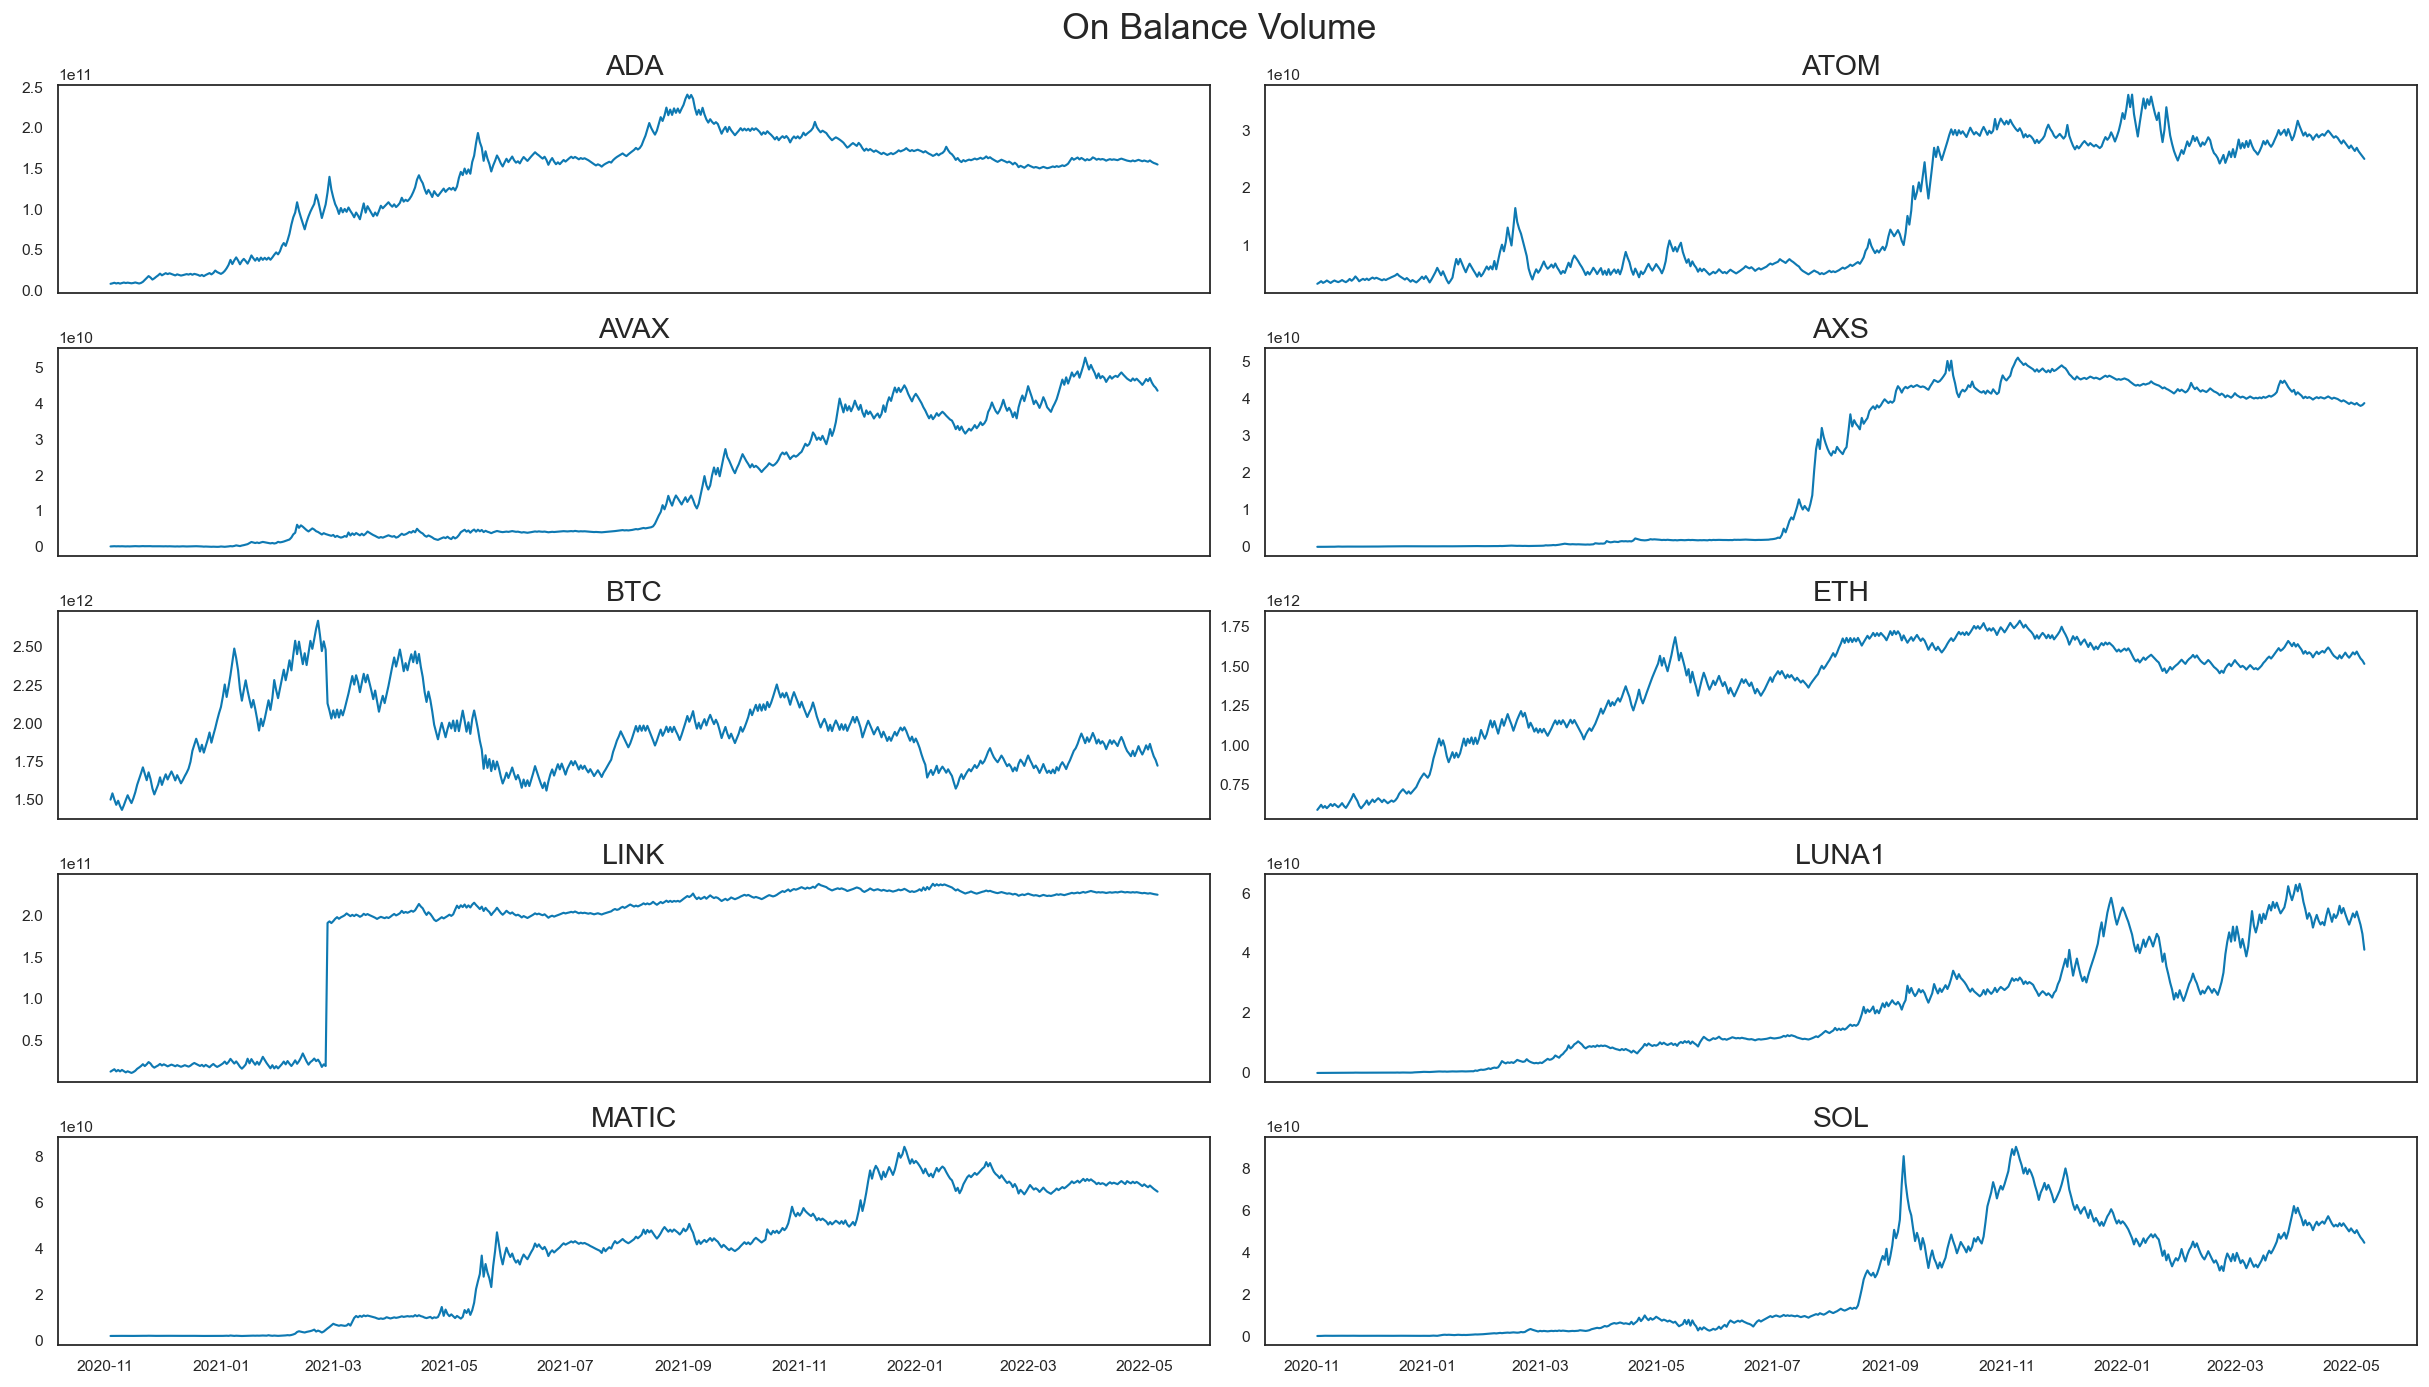

In [57]:
## Plot OBV
fig, axes = plt.subplots(5,2, figsize=(19,11), sharex=True, sharey=False)

for dfi in range(len(df_coins_list)):
    ax = axes.flatten()[dfi]
    plot_prefix = df_coins_suff[dfi]
    ax.set_title(str.upper(plot_prefix), fontsize=16)
    
    #ax.plot(df_all_ta[[plot_prefix+'_close']], label='Close', color=CAT_COLORS[0])
    ax.plot(df_all_ta[[plot_prefix+'_volume_obv']], label='OBV', color=CAT_COLORS[1])
        
    

fig.suptitle('On Balance Volume', fontsize=20)
plt.tight_layout()
save_fig('OBV', fig)

plt.show()

## Export data

In [58]:
df_merged = df_merged.loc[df_merged['Date']>='01-01-2021',:].reset_index(drop=True)


In [59]:
#df_all_ta = df_all_ta.loc[df_all_ta['Date']>='01-01-2021',:].reset_index(drop=True)

In [60]:
DATA_OUT_PATH

'../../data_out/'

In [61]:
df_merged.to_csv(DATA_OUT_PATH+"merged_data.csv", index=False)

In [62]:
df_merged.head(3)

,Date,ada_close,ada_high,ada_low,ada_open,ada_volume,atom_close,atom_high,atom_low,atom_open,...,luna1_trend_macd,luna1_volatility_atr,matic_volume_obv,matic_momentum_rsi,matic_trend_macd,matic_volatility_atr,sol_volume_obv,sol_momentum_rsi,sol_trend_macd,sol_volatility_atr
0,2021-01-01,0.175350,0.184246,0.172022,0.181382,1.122218e+09,5.868556,6.506998,5.652401,6.490297,...,0.053993,0.051369,2.036519e+09,47.984858,-0.000144,0.001536,255658268.0,57.385950,-0.050738,0.191277
1,2021-01-02,0.177423,0.184253,0.169233,0.175359,1.408850e+09,5.414613,5.882211,5.319140,5.869282,...,0.053286,0.049277,2.053894e+09,53.344082,-0.000058,0.001609,223987204.0,55.832142,-0.027803,0.198930
2,2021-01-03,0.204995,0.208679,0.173376,0.177382,2.303858e+09,5.813898,5.900645,5.301713,5.416301,...,0.054555,0.049605,2.071803e+09,56.959753,0.000084,0.001614,279060626.0,64.577875,0.019398,0.235608


In [63]:
df_all_ta.head(3)

,ada_close,ada_high,ada_low,ada_open,ada_volume,atom_close,atom_high,atom_low,atom_open,atom_volume,...,sol_momentum_ppo,sol_momentum_ppo_signal,sol_momentum_ppo_hist,sol_momentum_pvo,sol_momentum_pvo_signal,sol_momentum_pvo_hist,sol_momentum_kama,sol_others_dr,sol_others_dlr,sol_others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-04,0.095369,0.096002,0.092127,0.093435,1.041738e+09,4.385509,4.481732,4.220258,4.476964,313836974.0,...,-14.628623,-13.503849,-1.124774,-9.284271,-7.404186,-1.880085,1.546619,-1.414709,-1.424811,46.390739
2020-11-05,0.096994,0.097573,0.092214,0.095369,5.544965e+08,4.513780,4.578264,4.280948,4.385519,203956085.0,...,-14.603990,-13.723878,-0.880112,-8.992262,-7.721801,-1.270460,1.533339,0.931084,0.926776,47.753759
2020-11-06,0.109105,0.109683,0.096721,0.096994,7.177312e+08,4.871086,4.938119,4.479229,4.513771,250264715.0,...,-11.946985,-13.368499,1.421514,1.918529,-5.793735,7.712264,1.544108,36.188124,30.886701,101.223073
